# Section 4.5 — Model selection

This notebook contains the code examples from [Section 4.5 Model selection]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/lm/modelselection"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import norm
from scipy.stats import binom
from scipy.stats import bernoulli

## Fork

In [5]:
# U = 2 * np.random.binomial(1, 0.5, N) - 1
# G = np.random.normal(size=N)
# P = np.random.normal(b_GP * G + b_U * U)
# C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
# d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

In [6]:
# n <- 1000
# Z <- rbern( n , 0.5 )
# X <- rbern( n , (1-Z)*0.1 + Z*0.9 )
# Y <- rbern( n , (1-Z)*0.1 + Z*0.9 )


# cols <- c(4,2)
# N <- 300
# Z <- rbern(N)
# X <- rnorm(N,2*Z-1)
# Y <- rnorm(N,2*Z-1)
# plot( X , Y , col=cols[Z+1] , lwd=3 )
# abline(lm(Y[Z==1]~X[Z==1]),col=2,lwd=3)
# abline(lm(Y[Z==0]~X[Z==0]),col=4,lwd=3)
# abline(lm(Y~X),lwd=3)

### Example
Example 2 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [7]:
np.random.seed(1897)
n = 1000
iqs = norm(100,15).rvs(n)
ltimes = 200 - iqs + norm(0,1).rvs(n) 
tscores = 0.5*iqs + 0.1*ltimes + norm(0,1).rvs(n)

df2 = pd.DataFrame({
    "iq":iqs,
    "ltime": ltimes,
    "tscore": tscores
})

In [8]:
lm2a = smf.ols("tscore ~ ltime", data=df2).fit()
lm2a.params

Intercept    99.602100
ltime        -0.395873
dtype: float64

In [9]:
lm2b = smf.ols("tscore ~ ltime + iq", data=df2).fit()
lm2b.params

Intercept    3.580677
ltime        0.081681
iq           0.482373
dtype: float64

## Pipe

In [10]:
# SR example
# cols <- c(4,2)
# N <- 300
# X <- rnorm(N)
# Z <- rbern(N,inv_logit(X))
# Y <- rnorm(N,(2*Z-1))
# plot( X , Y , col=cols[Z+1] , lwd=3 )
# abline(lm(Y[Z==1]~X[Z==1]),col=2,lwd=3)
# abline(lm(Y[Z==0]~X[Z==0]),col=4,lwd=3)
# abline(lm(Y~X),lwd=3)


### Example
Example 1 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [11]:

np.random.seed(1896)
n = 1000
learns = norm(0,1).rvs(n)
knows = 5*learns + norm(0,1).rvs(n)
undstds = 3*knows + norm(0,1).rvs(n)

df1 = pd.DataFrame({
    "learn":learns,
    "know": knows,
    "undstd": undstds
})

In [12]:
lm1a = smf.ols("undstd ~ learn", data=df1).fit()
lm1a.params

Intercept    -0.045587
learn        14.890022
dtype: float64

In [13]:
lm1b = smf.ols("undstd ~ learn + know", data=df1).fit()
lm1b.params

Intercept   -0.036520
learn        0.130609
know         2.975806
dtype: float64

## Collider

In [14]:
# cols <- c(4,2)
# N <- 300
# X <- rnorm(N)
# Y <- rnorm(N)
# Z <- rbern(N,inv_logit(2*X+2*Y-2))
#  plot( X , Y , col=cols[Z+1] , lwd=3 )
# abline(lm(Y[Z==1]~X[Z==1]),col=2,lwd=3)
# abline(lm(Y[Z==0]~X[Z==0]),col=4,lwd=3)
# abline(lm(Y~X),lwd=3)

### Example
Example 3 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [15]:
np.random.seed(42)
n = 1000

ntwks = norm(0,1).rvs(n)
comps = norm(0,1).rvs(n)
boths = ((ntwks > 1) | (comps > 1))
lucks = bernoulli(0.05).rvs(n)
proms = (1 - lucks)*boths + lucks*(1 - boths)

df3 = pd.DataFrame({
    "ntwk":ntwks,
    "comp": comps,
    "prom": proms,
})

Without adjusting for the collider `prom`,
there is almost no effect of the network ability on competence.

In [16]:
lm3a = smf.ols("comp ~ ntwk", data=df3).fit()
lm3a.params

Intercept    0.071632
ntwk        -0.041152
dtype: float64

But with adjustment for `prom`,
there seems to be a negative effect.

In [17]:
lm3b = smf.ols("comp ~ ntwk + prom", data=df3).fit()
lm3b.params

Intercept   -0.290081
ntwk        -0.239975
prom         1.087964
dtype: float64

The false negative effect can also appear from sampling bias,
e.g. if we restrict our analysis only to people who were promoted.

In [18]:
df3proms = df3[df3["prom"]==1]
lm3c = smf.ols("comp ~ ntwk", data=df3proms).fit()
lm3c.params

Intercept    0.898530
ntwk        -0.426244
dtype: float64

## Selection bias

## Benefits of random assignment

### Example
Example 4 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [19]:
np.random.seed(1896)
n = 1000

iqs = norm(100,15).rvs(n)
groups = bernoulli(p=0.5).rvs(n)
ltimes_exp = 80*groups + 120*(1-groups)
tscores = 0.5*iqs + 0.1*ltimes_exp + norm(0,1).rvs(n)

df4 = pd.DataFrame({
    "iq":iqs,
    "ltime": ltimes_exp,
    "tscore": tscores
})

In [20]:
# non-randomized            # random assignment
df2.corr()["iq"]["ltime"],  df4.corr()["iq"]["ltime"]

(-0.9979264589333364, -0.020129851374243963)

In [21]:
df4.groupby("ltime")["iq"].mean()

ltime
80     99.980423
120    99.358152
Name: iq, dtype: float64

In [22]:
lm4a = smf.ols("tscore ~ ltime", data=df4).fit()
lm4a.params

Intercept    50.688293
ltime         0.091233
dtype: float64

In [23]:
lm4b = smf.ols("tscore ~ ltime + iq", data=df4).fit()
lm4b.params

Intercept   -0.303676
ltime        0.099069
iq           0.503749
dtype: float64

In [24]:
lm4c = smf.ols("tscore ~ iq", data=df4).fit()
lm4c.params

Intercept    9.896117
iq           0.501168
dtype: float64

## Variable selection

In [25]:
# load the dataset
doctors = pd.read_csv("../datasets/doctors.csv")

# fit the short model
formula2 = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula2, data=doctors).fit()

# fit long model with caffeine
formula2c = "score ~ 1 + alc + weed + exrc + caf"
lm2c = smf.ols(formula2c, data=doctors).fit()

# fit long model with useless varaible
formula2p = "score ~ 1 + alc + weed + exrc + permit"
lm2p = smf.ols(formula2p, data=doctors).fit()

### Comparing metrics

In [26]:
lm2.aic, lm2c.aic, lm2p.aic

(1103.2518084235273, 1092.066440497514, 1102.6030626936558)

In [27]:
lm2.bic, lm2c.bic, lm2p.bic

(1115.4512324525256, 1107.3157205337616, 1117.8523427299035)

In [28]:
lm2.fvalue, lm2c.fvalue, lm2p.fvalue

(270.34350189265825, 222.5179385249417, 205.51932993062275)

### F-test for the submodel

cf. https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.compare_f_test.html

In [29]:
F, p, _ = lm2c.compare_f_test(lm2)
F, p

(13.317646938672352, 0.0003615980907285796)

The $p$-value is smaller than $0.05$,
so we conclude that adding the variable `caf` improves the model.

In [30]:
F, p, _ = lm2p.compare_f_test(lm2)
F, p

(2.585739730738225, 0.10991892492566188)

The $p$-value is greater than $0.05$,
so we conclude that adding the variable `permit` doesn't improve the model.

### Likelihood ratio test

In [31]:
lm2c.compare_lr_test(lm2)

(13.185367926013441, 0.0002821434157606992, 1.0)

In [32]:
lm2p.compare_lr_test(lm2)

(2.648745729871507, 0.10363163447814171, 1.0)

### Lagrange multiplier test (optional)

In [33]:
# workaround to avoid bug
lm2_np = sm.OLS(lm2.model.endog, lm2.model.exog).fit()
lm2c_np = sm.OLS(lm2c.model.endog, lm2c.model.exog).fit()

# Lagrange Multiplier test to check short model
lm2c_np.compare_lm_test(lm2_np)

(12.643516756348614, 0.0003768703584529868, 1.0)

## Explanations

## Discussion

## Exercises

## Links

# CUT MATERIAL 


## Players dataset

In [34]:
players_full = pd.read_csv("../datasets/players_full.csv")

### Plot of linear model for `time ~ 1 + age`

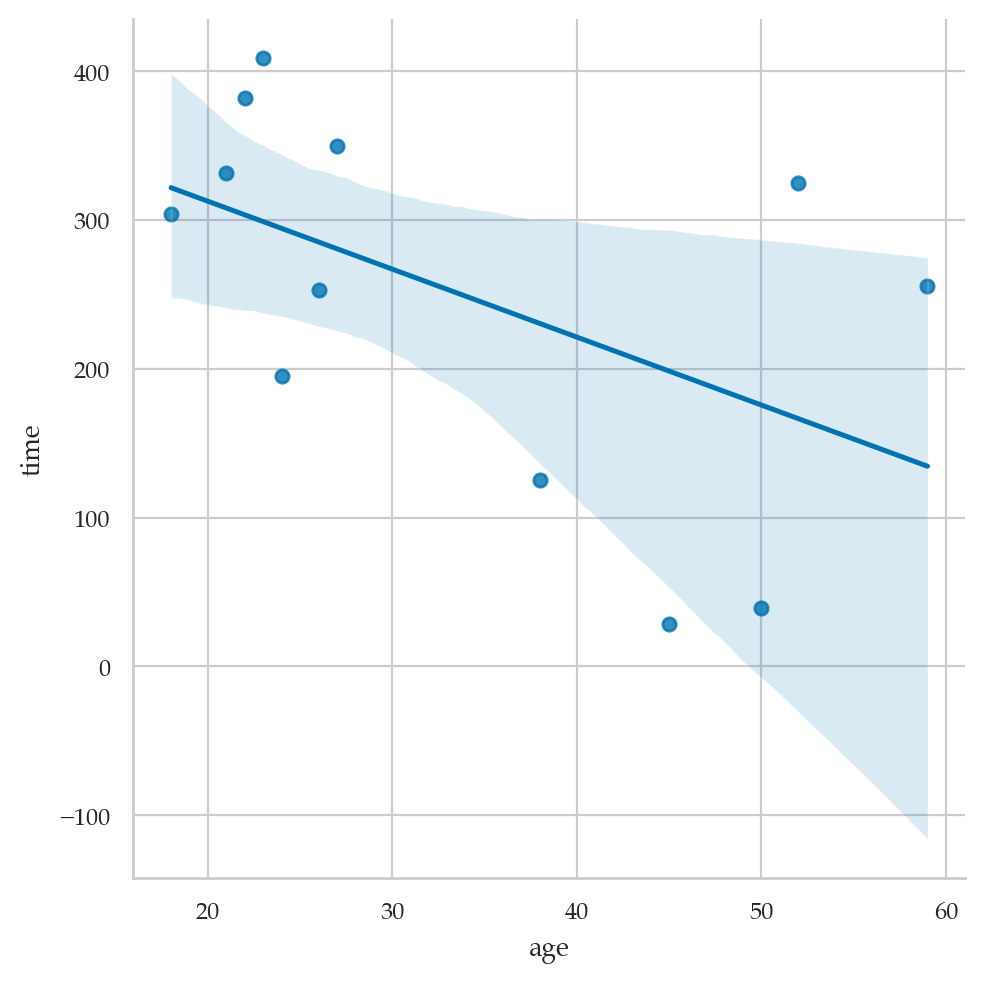

In [35]:
sns.lmplot(x="age", y="time", data=players_full)

In [36]:
import statsmodels.formula.api as smf

model1 = smf.ols('time ~ 1 + age', data=players_full)
result1 = model1.fit()
result1.summary()

/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     3.516
Date:                Wed, 01 May 2024   Prob (F-statistic):             0.0902
Time:                        13:24:05   Log-Likelihood:                -72.909
No. Observations:                  12   AIC:                             149.8
Df Residuals:                      10   BIC:                             150.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    403.8531     88.666      4.555      0.001     206.292     601.414
age           -4.5658      2.435     -1.875      0.090      -9.991       0.859
==============================================================================
Omnibus:                        2.175   Durbin-Watson:                   2.490
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                0.930
Skew:                          -0.123   Prob(JB):                        0.628
Kurtosis:                       1.659   Cond. No.                         97.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plot of linear model for `time ~ 1 + age + jobstatus`

We can "control for `jobstatus`" by including the variable in the linear model.
Essentially,
we're fitting two separate models,
one for `jobstatus=0` players and one for `jobstatus=1` players.


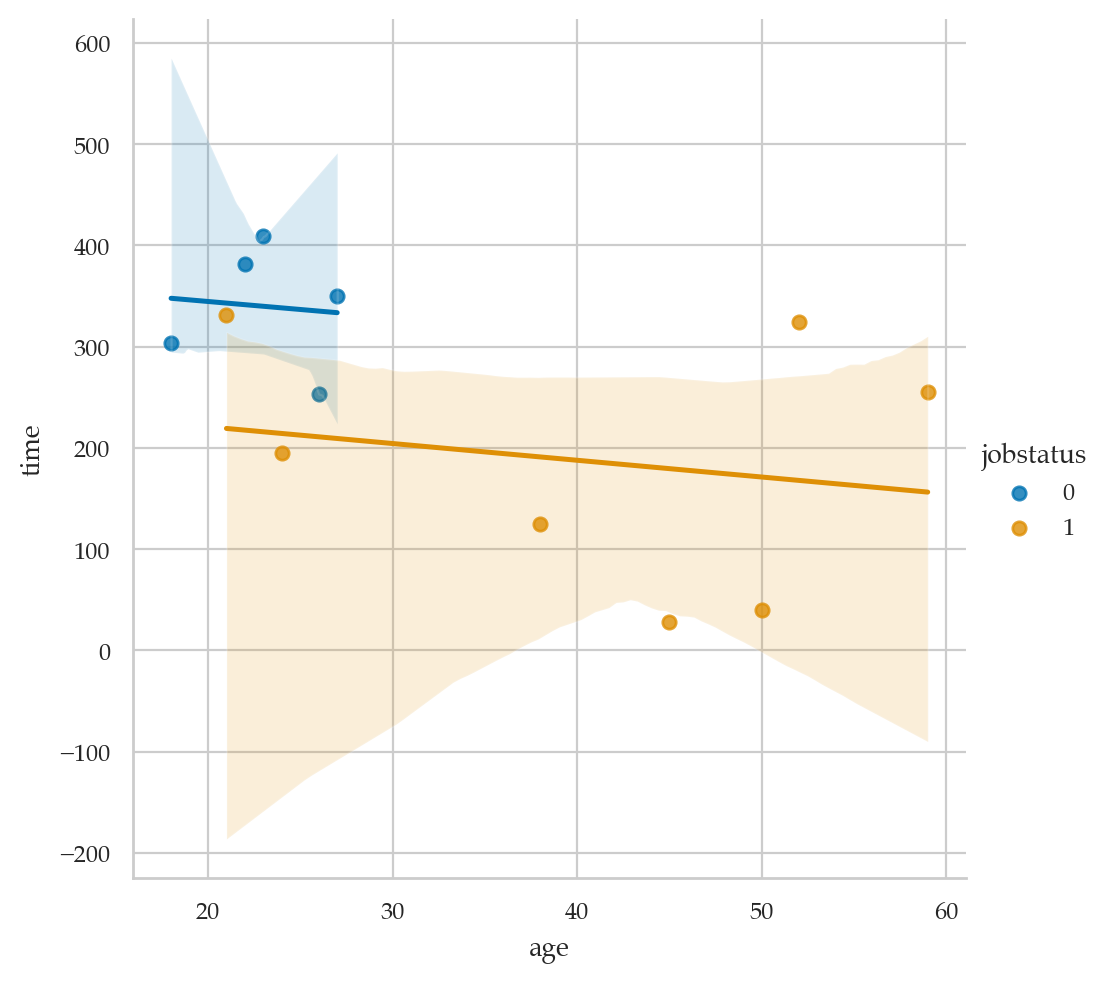

In [37]:
sns.lmplot(x="age", y="time", hue="jobstatus", data=players_full)

In [38]:
import statsmodels.formula.api as smf

model2 = smf.ols('time ~ 1 + age + C(jobstatus)', data=players_full)
result2 = model2.fit()
result2.params
# print(result2.summary().as_text())

Intercept            377.817172
C(jobstatus)[T.1]   -124.013781
age                   -1.650913
dtype: float64

#### Manual select subset with jobstatus 1

In [39]:
# import statsmodels.formula.api as smf

# players_job1 = players_full[players_full["jobstatus"]==1]
# model3 = smf.ols('time ~ 1 + age', data=players_job1)
# result3 = model3.fit()
# result3.summary()

### Example confoudouder  2

via https://stats.stackexchange.com/a/17338/62481

In [40]:
import numpy as np
from scipy.stats import uniform, randint

covariate = randint(0,2).rvs(100)
exposure  = uniform(0,1).rvs(100) +  0.3 * covariate
outcome   = 2.0 + 0.5*exposure + 0.25*covariate

# covariate, exposure, outcome
df2 = pd.DataFrame({
    "covariate":covariate,
    "exposure":exposure,
    "outcome":outcome
})

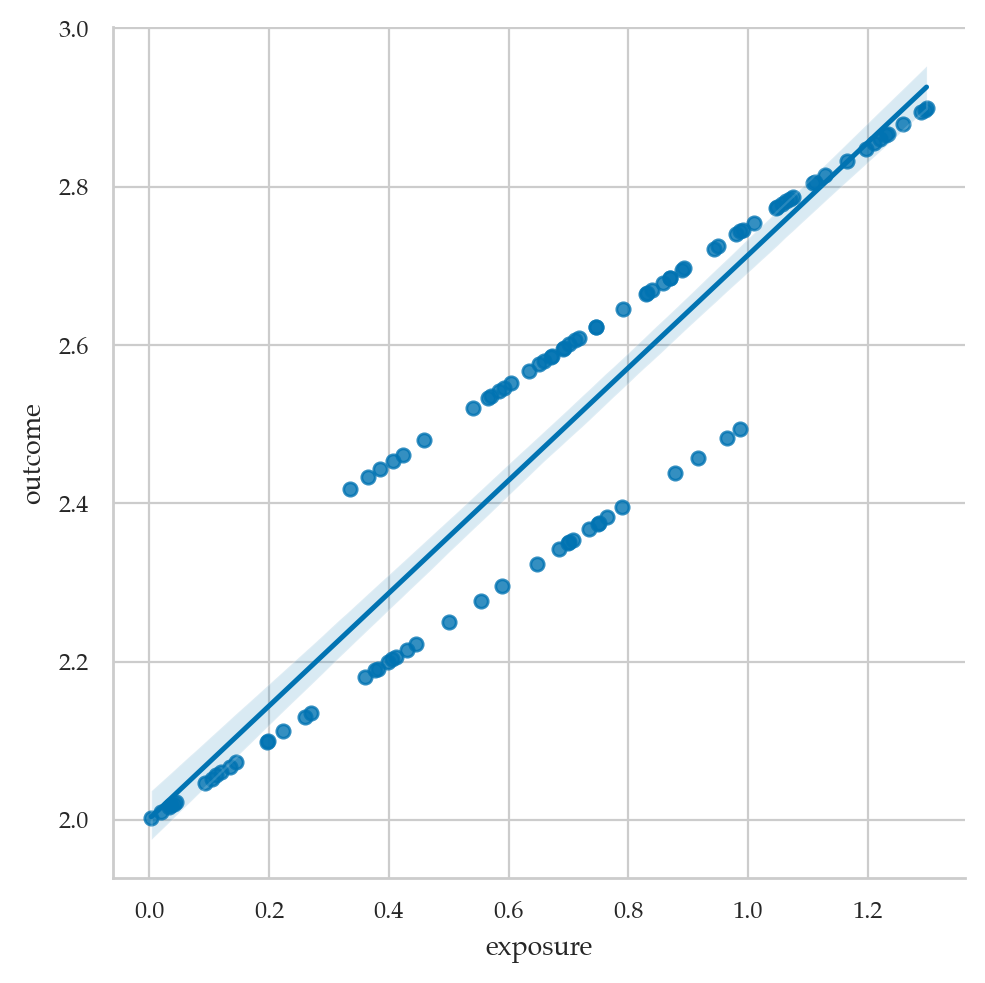

In [41]:
sns.lmplot(x="exposure", y="outcome", data=df2)

In [42]:
import statsmodels.formula.api as smf

model2a = smf.ols('outcome ~ exposure', data=df2)
result2a = model2a.fit()
# result2a.summary()
result2a.params

Intercept    2.001411
exposure     0.712343
dtype: float64

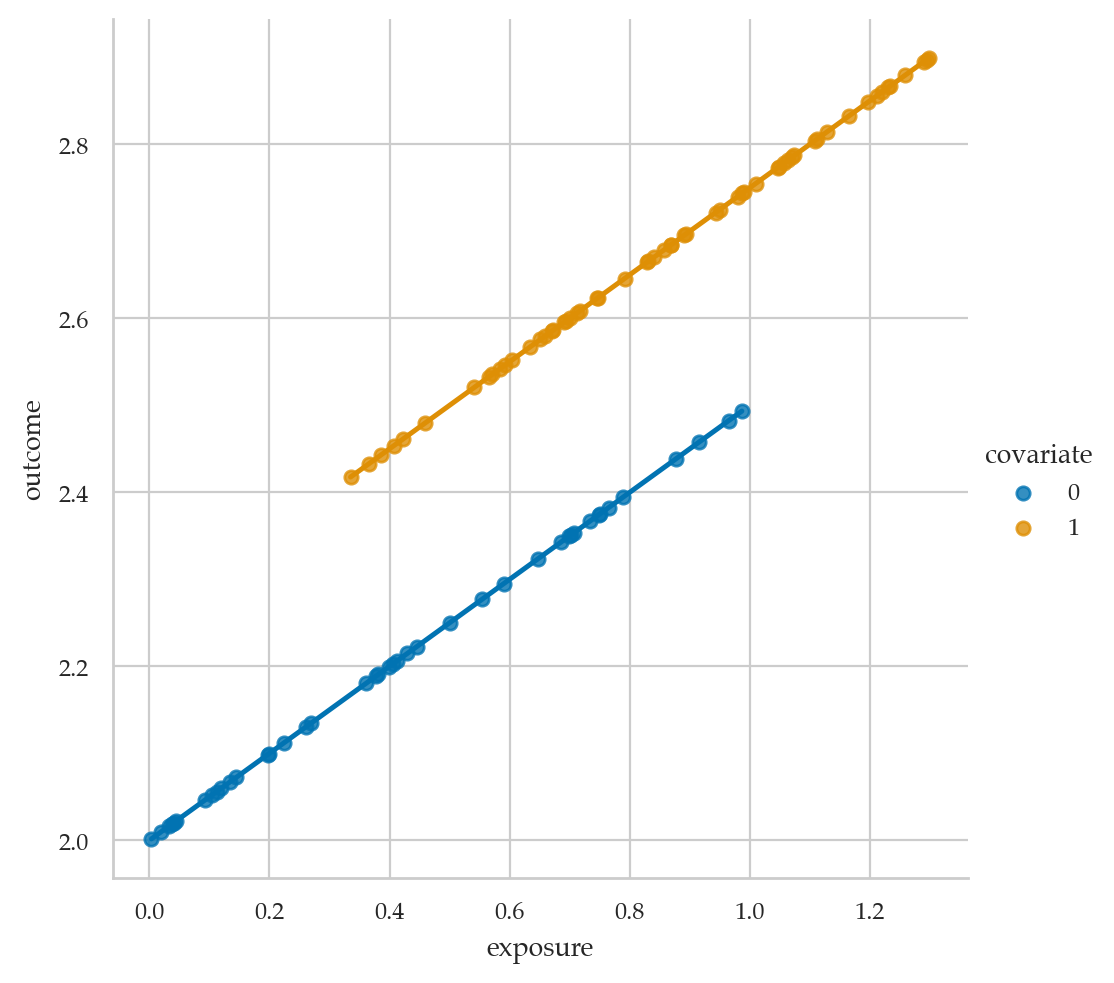

In [43]:
fg = sns.lmplot(x="exposure", y="outcome", hue="covariate", data=df2)

In [44]:
model2b = smf.ols('outcome ~ exposure + C(covariate)', data=df2)
result2b = model2b.fit()
# result2b.summary()
result2b.params

Intercept            2.00
C(covariate)[T.1]    0.25
exposure             0.50
dtype: float64

In [45]:
x = np.linspace(0,1.4)

m = result2b.params["exposure"]
b0 = result2b.params["Intercept"]
b1 = b0 + result2b.params["C(covariate)[T.1]"]

b0, b1

y0 = b0 + m*x
y1 = b1 + m*x
ax = fg.figure.axes[0]
sns.lineplot(x=x, y=y0, ax=ax, color="r")
sns.lineplot(x=x, y=y1, ax=ax, color="m")

<Axes: xlabel='exposure', ylabel='outcome'>

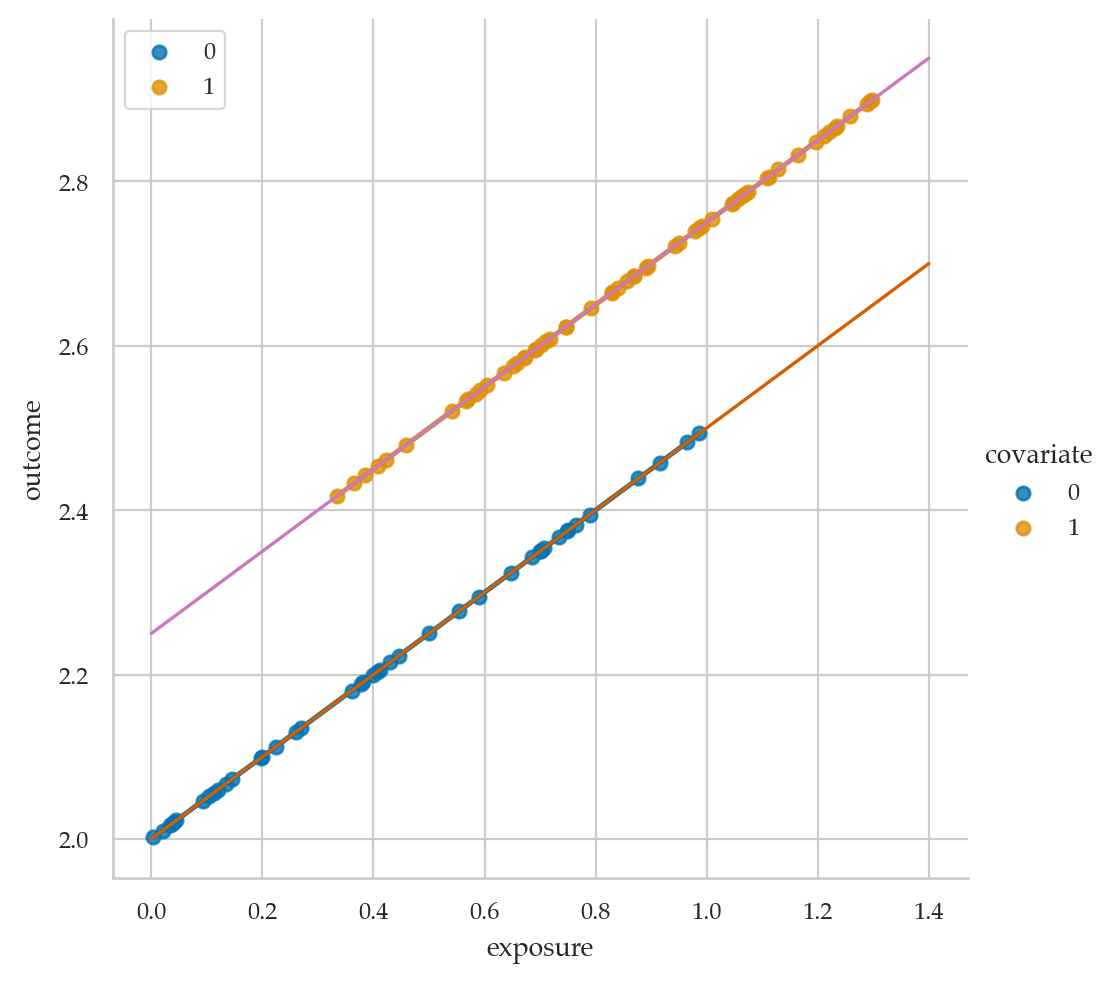

In [46]:
fg.figure

In [47]:
model2c = smf.ols('outcome ~ -1 + exposure*C(covariate)', data=df2)
result2c = model2c.fit()
result2c.summary()
# result2c.params

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.931e+29
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        13:24:08   Log-Likelihood:                 3223.2
No. Observations:                 100   AIC:                            -6438.
Df Residuals:                      96   BIC:                            -6428.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
C(covariate)[0]                2.0000   6.68e-16   2.99e+15      0.000       2.000       2.000
C(covariate)[1]                2.2500    1.1e-15   2.05e+15      0.000       2.250       2.250
exposure                       0.5000   1.29e-15   3.88e+14      0.000       0.500       0.500
exposure:C(covariate)[T.1]  -2.22e-16   1.77e-15     -0.125      0.901   -3.74e-15     3.3e-15
==============================================================================
Omnibus:                     3643.656   Durbin-Watson:                   0.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.221
Skew:                          -0.356   Prob(JB):                      0.00135
Kurtosis:                       1.367   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# df = sns.load_dataset('iris')
# sns.regplot(x=df["sepal_length"], y=df["sepal_width"], line_kws={"color":"r","alpha":0.7,"lw":5})

### Random slopes and random intercepts

via https://patsy.readthedocs.io/en/latest/quickstart.html

You can even write interactions between categorical and numerical variables.
Here we fit two different slope coefficients for x1; one for the a1 group, and one for the a2 group:
`dmatrix("a:x1", data)`

This is what matches the seaborn plot when using `hue` as an extra variable

In [49]:
model2d = smf.ols('outcome ~ 1 + C(covariate) + C(covariate):exposure', data=df2)
result2d = model2d.fit()
# result2d.summary()
result2d.params

Intercept                   2.00
C(covariate)[T.1]           0.25
C(covariate)[0]:exposure    0.50
C(covariate)[1]:exposure    0.50
dtype: float64

In [50]:
import numpy as np
from scipy.stats import uniform, randint

covariate3 = randint(0,2).rvs(100)
exposure3  = uniform(0,1).rvs(100) +  0.3 * covariate
outcome3   = 2.0 + 0.25*covariate3 + (0.5 + 0.1*covariate3)*exposure3 
#                  \             /    \                  /
#                  different inst.      different slopes  

df3 = pd.DataFrame({
    "covariate":covariate3,
    "exposure":exposure3,
    "outcome":outcome3
})


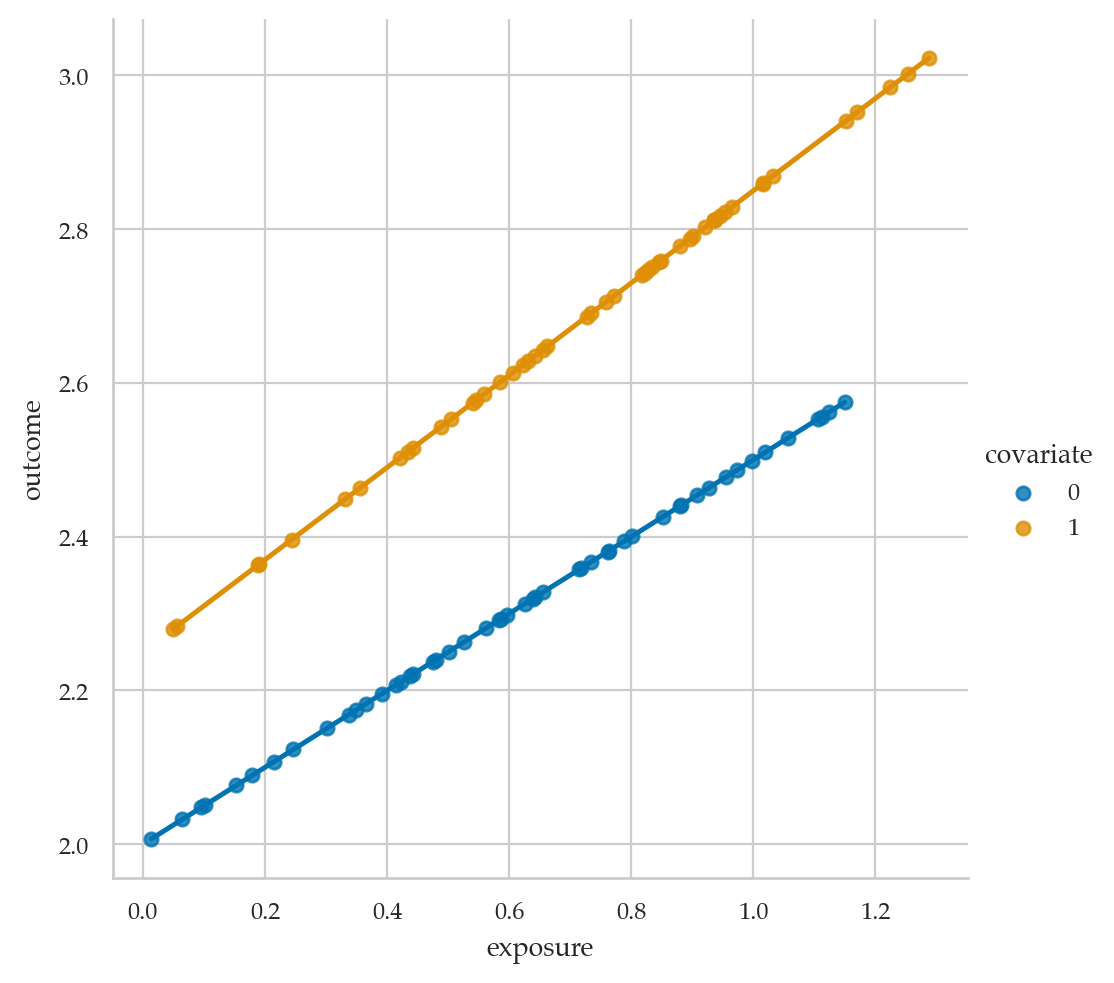

In [51]:
fg = sns.lmplot(x="exposure", y="outcome", hue="covariate", data=df3)

In [52]:
model3d = smf.ols('outcome ~ 1 + C(covariate) + C(covariate):exposure', data=df3)
result3d = model3d.fit()
result3d.params

Intercept                   2.00
C(covariate)[T.1]           0.25
C(covariate)[0]:exposure    0.50
C(covariate)[1]:exposure    0.60
dtype: float64

In [53]:
# ALT.
model3e = smf.ols('outcome ~ 0 + C(covariate) + C(covariate):exposure', data=df3)
result3e = model3e.fit()
result3e.params

C(covariate)[0]             2.00
C(covariate)[1]             2.25
C(covariate)[0]:exposure    0.50
C(covariate)[1]:exposure    0.60
dtype: float64